## 导入依赖

In [32]:
import pandas
import numpy as np
import math
from matplotlib import pyplot as plt
import yaml
from scipy import optimize as opt
from scipy.optimize import minimize # , rosen, rosen_der
from mpl_toolkits.mplot3d import Axes3D  # 空间三维画图


## 读入机器人的配置文件

In [33]:
config_path = "../config/arm4dof.yaml"
arm = None
with open(config_path, 'r', encoding="utf-8") as f:
    arm = yaml.load(f.read(),  Loader=yaml.SafeLoader)

In [34]:
link23 = arm['link']['link23']
link34 = arm['link']['link34']
link45 = arm['link']['link45']
link56 = arm['tool']['pump']['tool_offset']['z']

## 从Excel中导入标定数据

In [35]:
raw_data_df = pandas.read_excel('机械臂几何标定-十六点舵机原始角度数据.xlsx')
raw_data_df

,点位ID,x坐标,y坐标,z坐标,舵机0,舵机1,舵机2,舵机3
0,1,19.5,4.5,-8.5,-14.8,80.2,-4.2,37.0
1,2,19.5,1.5,-8.5,-6.2,77.3,-11.2,38.3
2,3,19.5,-1.5,-8.5,3.8,77.3,-11.2,38.3
3,4,19.5,-4.5,-8.5,13.1,83.2,-2.9,39.1
4,5,16.5,4.5,-8.5,-18.2,66.0,-43.7,56.8
5,6,16.5,1.5,-8.5,-6.9,66.3,-51.9,68.6
6,7,16.5,-1.5,-8.5,4.3,66.3,-51.9,68.6
7,8,16.5,-4.5,-8.5,15.2,69.5,-46.7,68.8
8,9,13.5,4.5,-8.5,-21.0,56.6,-70.4,73.0
9,10,13.5,1.5,-8.5,-8.1,58.8,-79.0,86.7


In [38]:
raw_data_df.columns

Index(['点位ID', 'x坐标', 'y坐标', 'z坐标', '舵机0', '舵机1', '舵机2', '舵机3'], dtype='object')

In [42]:
raw_data_df['x坐标'].to_numpy()

array([19.5, 19.5, 19.5, 19.5, 16.5, 16.5, 16.5, 16.5, 13.5, 13.5, 13.5,
       13.5, 10.5, 10.5, 10.5, 10.5])

转换为ndarray

In [43]:

x_arr = raw_data_df['x坐标'].to_numpy()
y_arr = raw_data_df['y坐标'].to_numpy()
z_arr = raw_data_df['z坐标'].to_numpy()

s0_arr =  raw_data_df['舵机0'].to_numpy()
s1_arr =  raw_data_df['舵机1'].to_numpy()
s2_arr =  raw_data_df['舵机2'].to_numpy()
s3_arr =  raw_data_df['舵机3'].to_numpy()

In [46]:
# 当theta1 = 0时，x,y -> x0
d_arr = np.sqrt(np.power(x_arr,2) + np.power(y_arr, 2))

In [45]:
 # 舵机原始角度转换为弧度
# 因为这样，偏导的公式比较好求
s1_arr_rad = np.radians(s1_arr)
s2_arr_rad = np.radians(s2_arr)
s3_arr_rad = np.radians(s3_arr)

## 计算标定数据的初始值

In [47]:
# 计算关节1的标定系数
theta1_n90 = arm['joint']['joint2servo_data']['theta1_n90']
theta1_p90 = arm['joint']['joint2servo_data']['theta1_p90']
k1_ref = (theta1_p90 - theta1_n90) / (90.0 - (-90.0))
b1_ref = theta1_p90 - k1_ref*90.0
# 计算关节2的标定系数
theta2_n90 = arm['joint']['joint2servo_data']['theta2_n90']
theta2_p0 = arm['joint']['joint2servo_data']['theta2_p0']
k2_ref = (theta2_p0 - theta2_n90) / (0.0 - (-90.0))
b2_ref = theta2_p0 - k2_ref*0.0
# 计算关节3的标定系数
theta3_p0 = arm['joint']['joint2servo_data']['theta3_p0']
theta3_p90 = arm['joint']['joint2servo_data']['theta3_p90']
k3_ref = (theta3_p90 - theta3_p0) / (90.0 - (0.0))
b3_ref = theta3_p90 - k3_ref*90.0
# 计算关节4的标定系数
theta4_n90 = arm['joint']['joint2servo_data']['theta4_n90']
theta4_p90 = arm['joint']['joint2servo_data']['theta4_p90']
k4_ref = (theta4_p90 - theta4_n90) / (90.0 - (-90.0))
b4_ref = theta4_p90 - k4_ref*90.0

## 标定关节1

关节1跟关节2,3,4相对独立，所以可以单独进行标定

In [10]:
theta1_arr = np.zeros_like(x_arr)
for i in range(len(theta1_arr)):
    theta1_arr[i] = np.degrees(math.atan2(y_arr[i], x_arr[i]))

In [11]:
theta1_arr

array([ 12.99461679,   4.39870535,  -4.39870535, -12.99461679,
        15.2551187 ,   5.19442891,  -5.19442891, -15.2551187 ,
        18.43494882,   6.34019175,  -6.34019175, -18.43494882,
        23.19859051,   8.13010235,  -8.13010235, -23.19859051])

可视化

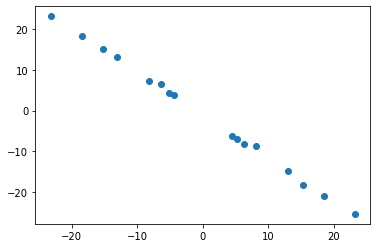

In [12]:
plt.scatter(theta1_arr, s0_arr)

可以看到他们几乎都分布在同一条直线上

实用最小二乘法进行拟合

In [13]:
k1, b1 = np.polyfit(theta1_arr, s0_arr, 1)
print("servo0 = theta1*{:.3f} + {:.3f}".format(k1, b1))

servo0 = theta1*-1.063 + -1.100


In [14]:
k1

-1.0626835448399374

In [15]:
b1

-1.1000000000000003

线性拟合的结果

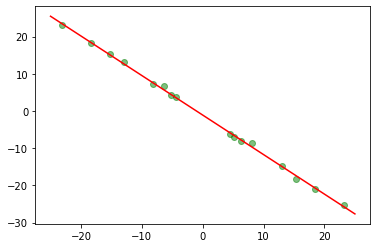

In [16]:
plt.scatter(theta1_arr, s0_arr, alpha=0.5, c='green')
x = np.array([-25, 25])
y = k1*x + b1
plt.plot(x, y, c='red')

In [17]:
theta1 = ((s0_arr - b1) / k1)/180.0 * np.pi

## 标定关节2-4

In [18]:
# 设定初始值
k2 = k2_ref
b2 = b2_ref
k3 = k3_ref
b3 = b3_ref
k4 = k4_ref
b4 = b4_ref

参考博客
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [19]:

def fk2d_residual(params):
    global z_workspace
    k2, b2, k3, b3, k4, b4 = params
    theta2 = ((s1_arr - b2) / k2)/180.0*np.pi
    theta3 = ((s2_arr - b3) / k3)/180.0* np.pi
    theta4 = ((s3_arr - b4) / k4)/180* np.pi
    theta23 = theta2+theta3
    theta234 = theta23 + theta4
    d_cur = link23*np.cos(theta2) + link34*np.cos(theta23) + link45*np.cos(theta234) - link56*np.sin(theta234)
    z_cur = -link23*np.sin(theta2) - link34*np.sin(theta23) - link45*np.sin(theta234) - link56*np.cos(theta234)
    x_cur = d_cur*np.cos(theta1)
    y_cur = d_cur*np.sin(theta1)
    
    return  np.sum(np.power(x_arr - x_cur, 2) + np.power(y_arr - y_cur, 2) + np.power(z_arr - z_cur, 2))


# BFGS: 0.23260137584604745 (默认是这个)
# CG: 0.23252056155601647 实际上跟BFGS差不多，小于0.01cm的差异，没有实际的意义
# TNC： 0.31575836463907314
# COBYLA: 0.669255993945074
# SLSQP: 0.23259624443637333
# trust-constr: 0.232599460337942
result = opt.minimize(fk2d_residual, [k2_ref, b2_ref, k3_ref, b3_ref, k4_ref, b4_ref], method='BFGS')

k2,b2, k3, b3, k4, b4  = result.x

print("[ref]    k2= {:.3f} b2= {:.3f} k3= {:.3f} b3= {:.3f} k4= {:.3f} b4= {:.3f}".format(k2_ref, b2_ref, k3_ref, b3_ref, k4_ref, b4_ref))
print("[optimal]k2= {:.4f} b2= {:.4f} k3= {:.4f} b3= {:.4f} k4= {:.4f} b4= {:.3f}".format(k2, b2, k3, b3, k4, b4))


# 评估算法的效果
theta2 = ((s1_arr - b2) / k2)/180.0 * np.pi
theta3 = ((s2_arr - b3) / k3)/180.0 * np.pi
theta4 = ((s3_arr - b4) / k4)/180 * np.pi
theta23 = theta2+theta3
theta234 = theta23 + theta4
d_after_cali = link23*np.cos(theta2) + link34*np.cos(theta23) + link45*np.cos(theta234) - link56*np.sin(theta234)
z_arr_sciopt = -link23*np.sin(theta2) - link34*np.sin(theta23) - link45*np.sin(theta234) -  link56*np.cos(theta234)
x_arr_sciopt = d_after_cali * np.cos(theta1)
y_arr_sciopt = d_after_cali * np.sin(theta1)
err_mean = np.mean(np.sqrt(np.power(x_arr - x_arr_sciopt, 2) +  np.power(y_arr - y_arr_sciopt, 2) + np.power(z_arr - z_arr_sciopt, 2)))

print("平均误差")
print(err_mean)

[ref]    k2= 0.987 b2= 84.100 k3= -1.043 b3= 42.800 k4= -1.004 b4= 0.500
[optimal]k2= 0.9744 b2= 93.8149 k3= -1.0440 b3= 45.9966 k4= -0.9367 b4= 10.850
平均误差
0.23260137584604745


[optimal]k2= 0.974 b2= 93.814 k3= -1.044 b3= 45.999 k4= -0.937 b4= 10.842

In [20]:
print(result)

      fun: 1.002207603449162
 hess_inv: array([[ 0.0060638 , -0.00356509,  0.00041974,  0.00117362,  0.00570701,
        -0.00963211],
       [-0.00356509,  0.00214928, -0.00022659, -0.00090013, -0.00327121,
         0.00572141],
       [ 0.00041974, -0.00022659,  0.0004152 , -0.00034195,  0.00125875,
        -0.00083755],
       [ 0.00117362, -0.00090013, -0.00034195,  0.00196792,  0.00029071,
        -0.00236608],
       [ 0.00570701, -0.00327121,  0.00125875,  0.00029071,  0.00753744,
        -0.00962867],
       [-0.00963211,  0.00572141, -0.00083755, -0.00236608, -0.00962867,
         0.01600545]])
      jac: array([ 4.30643559e-06, -7.45058060e-07,  7.12275505e-06, -1.23679638e-06,
       -2.26497650e-06, -3.87430191e-07])
  message: 'Optimization terminated successfully.'
     nfev: 860
      nit: 41
     njev: 107
   status: 0
  success: True
        x: array([ 0.97437902, 93.81490601, -1.04402856, 45.99655783, -0.93670351,
       10.84971667])


看到，优化的结果是成功的

## 可视化

旧的标定参数

In [22]:

theta2_old = ((s1_arr - b2_ref) / k2_ref)/180.0 * np.pi
theta3_old = ((s2_arr - b3_ref) / k3_ref)/180.0 * np.pi
theta4_old = ((s3_arr - b4_ref) / k4_ref)/180 * np.pi

theta23_old = theta2_old + theta3_old
theta234_old = theta23_old + theta4_old
d_before_cali = link23*np.cos(theta2_old) + link34*np.cos(theta23_old) + link45*np.cos(theta234_old) - link56*np.sin(theta234_old)
z_before_cali = -link23*np.sin(theta2_old) - link34*np.sin(theta23_old) - link45*np.sin(theta234_old) -  link56*np.cos(theta234_old)

x_before_cali = d_before_cali * np.cos(theta1)
y_before_cali = d_before_cali * np.sin(theta1)

新的标定参数

In [23]:
theta2 = ((s1_arr - b2) / k2)/180.0 * np.pi
theta3 = ((s2_arr - b3) / k3)/180.0 * np.pi
theta4 = ((s3_arr - b4) / k4)/180 * np.pi
theta23 = theta2+theta3
theta234 = theta23 + theta4
d_after_cali = link23*np.cos(theta2) + link34*np.cos(theta23) + link45*np.cos(theta234) - link56*np.sin(theta234)
z_after_cali = -link23*np.sin(theta2) - link34*np.sin(theta23) - link45*np.sin(theta234) -  link56*np.cos(theta234)
x_after_cali = d_after_cali * np.cos(theta1)
y_after_cali = d_after_cali * np.sin(theta1)

x_arr_sciopt = x_after_cali
y_arr_sciopt = y_after_cali
z_arr_sciopt = z_after_cali

np.mean(np.sqrt(np.power(x_arr - x_arr_sciopt, 2) +  np.power(y_arr - y_arr_sciopt, 2) + np.power(z_arr - z_arr_sciopt, 2)))


0.23260137584604745

In [24]:
d_arr

array([20.0124961 , 19.55760722, 19.55760722, 20.0124961 , 17.10263138,
       16.56804153, 16.56804153, 17.10263138, 14.23024947, 13.58307771,
       13.58307771, 14.23024947, 11.42365966, 10.60660172, 10.60660172,
       11.42365966])

In [ ]:
d_before_cali

In [ ]:
d_after_cali

In [ ]:
z_before_cali

In [ ]:
z_after_cali

## 笛卡尔空间下的标定效果

绘制网格

<IPython.core.display.Javascript object>


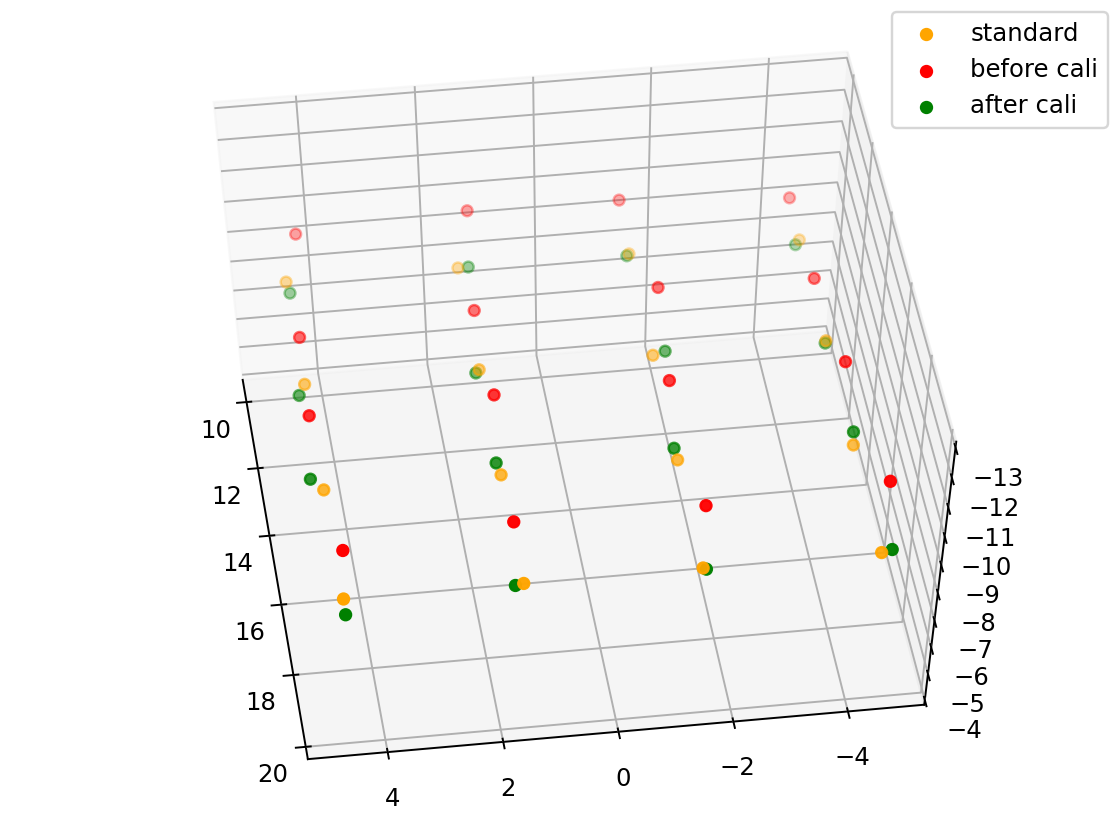

(-13.0, -4.0)

In [26]:
%matplotlib notebook
# 绘制散点图
fig = plt.figure()
ax = Axes3D(fig)

pts_std = ax.scatter(x_arr, y_arr, z_arr, c='orange') # 绘制标准网格
pts_before_cali = ax.scatter(x_before_cali, y_before_cali, z_before_cali, c='red')
pts_after_cali = ax.scatter(x_after_cali, y_after_cali, z_after_cali, c='green')

plt.legend(handles=[pts_std, pts_before_cali, pts_after_cali],labels=['standard','before cali', 'after cali'],loc='best')

ax.set_zlim3d(-13, -4)


<IPython.core.display.Javascript object>


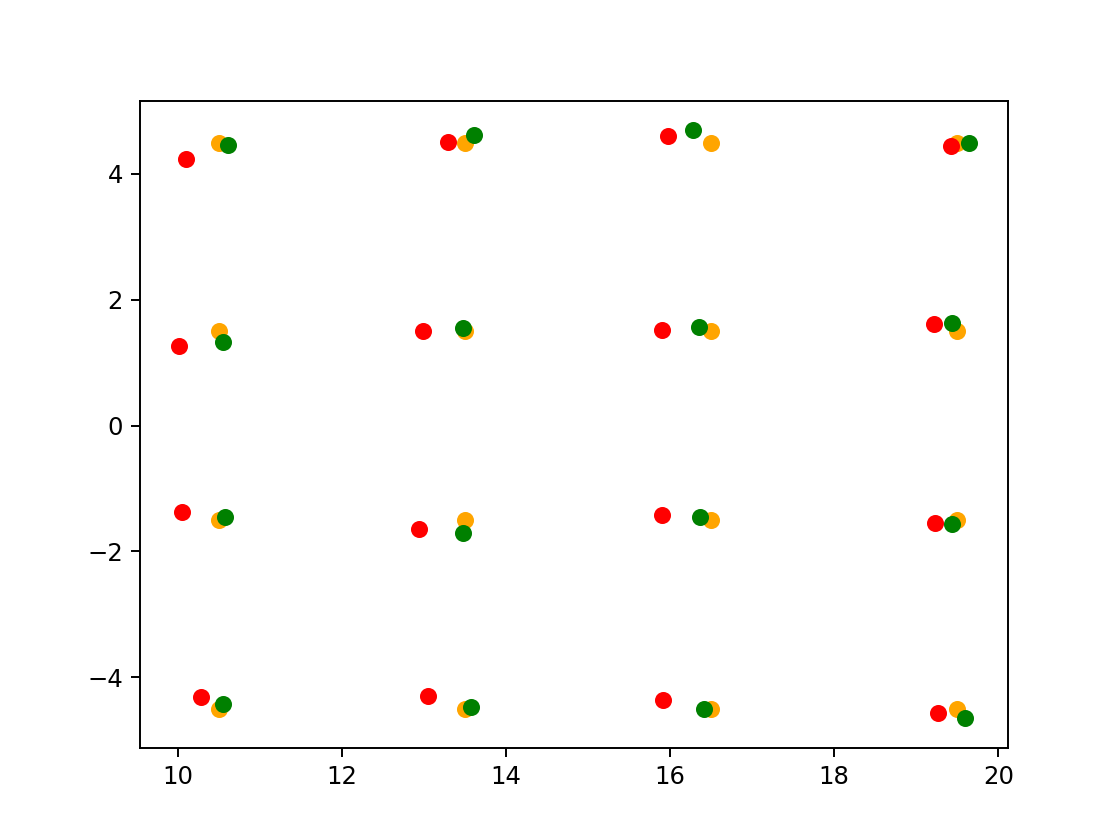

In [31]:
%matplotlib notebook
plt.scatter(x_arr, y_arr, c='orange')
plt.scatter(x_before_cali, y_before_cali, c='red')
plt.scatter(x_after_cali, y_after_cali, c='green')



## 重新标定连杆的长度

In [ ]:
def fk3d_residual_for_link(params):
    global z_workspace
    global theta1, theta2, theta3, theta4
    global x_arr, y_arr, z_arr
    
    link23, link34, link45, link56 = params
    
    theta23 = theta2+theta3
    theta234 = theta23 + theta4
    d_cur = link23*np.cos(theta2) + link34*np.cos(theta23) + link45*np.cos(theta234) - link56*np.sin(theta234)
    z_cur = -link23*np.sin(theta2) - link34*np.sin(theta23) - link45*np.sin(theta234) - link56*np.cos(theta234)
    x_cur = d_cur*np.cos(theta1)
    y_cur = d_cur*np.sin(theta1)
    
    return  np.sum(np.power(x_arr - x_cur, 2) + np.power(y_arr - y_cur, 2) + np.power(z_arr - z_cur, 2))


result = opt.minimize(fk3d_residual_for_link, [link23, link34, link45, link56])

link23_new, link34_new, link45_new, link56_new  = result.x

# print("[ref]    k2= {:.3f} b2= {:.3f} k3= {:.3f} b3= {:.3f} k4= {:.3f} b4= {:.3f}".format(k2_ref, b2_ref, k3_ref, b3_ref, k4_ref, b4_ref))
# print("[optimal]k2= {:.3f} b2= {:.3f} k3= {:.3f} b3= {:.3f} k4= {:.3f} b4= {:.3f}".format(k2, b2, k3, b3, k4, b4))

print("标定之前的连杆长度")
print("l23={:.3f} l34={:.3f} l45={:.3f} l56={:.3f}".format(link23, link34, link45, link56))

print("标定之后的连杆长度")
print("l23={:.3f} l34={:.3f} l45={:.3f} l56={:.3f}".format(link23_new, link34_new, link45_new, link56_new))


In [ ]:
result

可视化连杆标定的效果

In [ ]:

d_link_cali = link23_new * np.cos(theta2) + link34_new * np.cos(theta23) + link45_new * np.cos(theta234) - link56_new * np.sin(theta234)
z_link_cali = -link23_new * np.sin(theta2) - link34_new * np.sin(theta23) - link45_new * np.sin(theta234) -  link56_new * np.cos(theta234)
x_link_cali = d_link_cali * np.cos(theta1)
y_link_cali = d_link_cali * np.sin(theta1)

In [ ]:
%matplotlib notebook
# 绘制散点图
fig = plt.figure()
ax = Axes3D(fig)

pts_std = ax.scatter(x_arr, y_arr, z_arr, c='orange') # 绘制标准网格
pts_before_cali = ax.scatter(x_before_cali, y_before_cali, z_before_cali, c='red')
pts_after_cali = ax.scatter(x_after_cali, y_after_cali, z_after_cali, c='green')
pts_link_cali = ax.scatter(x_link_cali, y_link_cali, z_link_cali, c='purple')

plt.legend(handles=[pts_std, pts_before_cali, pts_after_cali],labels=['standard','before cali', 'after cali'],loc='best')

总体上来看，并没有什么特别大的变化, 标定前跟标定后几乎重合

## 批量梯度下降关节标定

公式推导-> 见附件

In [ ]:
d_arr

In [ ]:
def bgd(k2, b2, k3, b3, k4, b4, alpha, beta, n_step=100):
    '''批量梯度下降'''
    global d_arr, z_arr # 标准网格的坐标
    global s1_arr_rad, s2_arr_rad, s3_arr_rad # 舵机原始角度
    global link23,link34, link45, link56 # 连杆长度
    global k2_ref, b2_ref, k3_ref, b3_ref, k4_ref, b4_ref # 参考值
    target_d = d_arr
    target_z = z_arr
    
    # 参数的历史记录
    k2_hist = []
    b2_hist = []
    k3_hist = []
    b3_hist = []
    k4_hist = []
    b4_hist = []
    error_hist = []
    
    for i in range(n_step):
        # 更新关节角度
        theta2 = ((s1_arr_rad - b2) / k2)
        theta3 = ((s2_arr_rad - b3) / k3)
        theta4 = ((s3_arr_rad - b4) / k4)
        
        theta23 = theta2 + theta3
        theta234 = theta23 + theta4
        # 计算当前的末端位姿(正向运动学)
        x_cur = link23*np.cos(theta2) + link34*np.cos(theta23) + link45*np.cos(theta234) - link56*np.sin(theta234)
        z_cur = -link23*np.sin(theta2) - link34*np.sin(theta23) - link45*np.sin(theta234) - link56*np.cos(theta234)
        # 求误差
        x_err = x_cur - x_arr
        z_err = z_cur - z_arr
        # 误差平方的均值
        cur_error = np.mean(np.power(x_err, 2) + np.power(z_err, 2))
        error_hist.append(cur_error)
        # 求偏导数
        dx_dtheta4 = -link45*np.sin(theta234) -link56*np.cos(theta234)
        dx_dtheta3 = dx_dtheta4 - link34*np.sin(theta23)
        dx_dtheta2 = dx_dtheta3 - link23*np.sin(theta2)
        dz_dtheta4 = -link45*np.cos(theta234) + link56*np.sin(theta234)
        dz_dtheta3 = dz_dtheta4 - link34*np.cos(theta23)
        dz_dtheta2 = dz_dtheta3 - link23*np.cos(theta2)
        dtheta2_dk2 = (b2 - s1_arr)/(k2*k2)
        dtheta2_db2 = -1/k2
        dtheta3_dk3 = (b3 - s2_arr)/(k3*k3)
        dtheta3_db3 = -1/k3
        dtheta4_dk4 = (b4 - s3_arr)/(k4*k4)
        dtheta4_db4 = -1/k4
        # 批量梯度下降
        # print("{} ".format(i))
        # print(np.mean((dx_dtheta2*dtheta2_dk2)*x_err + (dz_dtheta2*dtheta2_dk2)*z_err))
        # print(np.mean((dx_dtheta2*dtheta2_db2)*x_err + (dz_dtheta2*dtheta2_db2)*z_err))
        k2 = k2 - alpha*np.mean((dx_dtheta2*dtheta2_dk2)*x_err + (dz_dtheta2*dtheta2_dk2)*z_err)
        b2 = b2 - beta*np.mean((dx_dtheta2*dtheta2_db2)*x_err + (dz_dtheta2*dtheta2_db2)*z_err)
        k3 = k3 - alpha*np.mean((dx_dtheta3*dtheta3_dk3)*x_err + (dz_dtheta3*dtheta3_dk3)*z_err)
        b3 = b3 - beta*np.mean((dx_dtheta3*dtheta3_db3)*x_err + (dz_dtheta3*dtheta3_db3)*z_err)
        k4 = k4 - alpha*np.mean((dx_dtheta4*dtheta4_dk4)*x_err + (dz_dtheta4*dtheta4_dk4)*z_err)
        b4 = b4 - beta*np.mean((dx_dtheta4*dtheta4_db4)*x_err + (dz_dtheta4*dtheta4_db4)*z_err)
        # 添加约束
        # 追加历史记录
        k2_hist.append(k2)
        b2_hist.append(b2)
        k3_hist.append(k3)
        b3_hist.append(b3)
        k4_hist.append(k4)
        b4_hist.append(b4)
    
    
    return (k2, b2, k3, b3, k4, b4), (np.float32(k2_hist), np.float32(b2_hist), np.float32(k3_hist), \
                                      np.float32(b3_hist), np.float32(k4_hist), np.float32(b4_hist), \
                                      np.sqrt(np.float32(error_hist)))

In [ ]:
cali_data, history = bgd(k2_ref, math.radians(b2_ref), k3_ref, math.radians(b3_ref), k4_ref, math.radians(b4_ref), alpha=0.00005, beta=0.001, n_step=4000)

k2_bgd, b2_bgd, k3_bgd, b3_bgd, k4_bgd, b4_bgd =  cali_data
k2_hist,b2_hist,k3_hist,b3_hist,k4_hist,b4_hist,error_hist = history

In [ ]:
print("批量梯度下降后的参数")
print("k2= {:.3f} b2= {:.3f} k3= {:.3f} b3= {:.3f} k4= {:.3f} b4= {:.3f}".format(k2_bgd, b2_bgd, k3_bgd, b3_bgd, k4_bgd, b4_bgd))

In [ ]:
# 更新关节角度
theta2 = ((s1_arr_rad - b2_bgd) / k2_bgd)
theta3 = ((s2_arr_rad - b3_bgd) / k3_bgd)
theta4 = ((s3_arr_rad - b4_bgd) / k4_bgd)

theta23 = theta2 + theta3
theta234 = theta23 + theta4
# 计算当前的末端位姿(正向运动学)
d_arr_bgd = link23*np.cos(theta2) + link34*np.cos(theta23) + link45*np.cos(theta234) - link56*np.sin(theta234)
z_arr_bgd = -link23*np.sin(theta2) - link34*np.sin(theta23) - link45*np.sin(theta234) - link56*np.cos(theta234)
x_arr_bgd = d_arr_bgd * np.cos(theta1)
y_arr_bgd = d_arr_bgd * np.sin(theta1)

显示参数变换以及误差变换的历史曲线

In [ ]:
%matplotlib notebook


fig = plt.figure()
ax = fig.subplots()


plt.title('BGD History')

t = np.linspace(0, len(k2_hist), len(k2_hist))
lk2 = ax.plot(t, k2_hist, label='k2')
lb2 = ax.plot(t, b2_hist, label='b2')
lk3 = ax.plot(t, k3_hist, label='k3')
lb3 = ax.plot(t, b3_hist, label='b3')
lk4 = ax.plot(t, k4_hist, label='k4')
lb4 = ax.plot(t, b4_hist, label='b4')
lerr = ax.plot(t, error_hist, label='err')

plt.legend(loc='upper right')


In [ ]:
%matplotlib notebook
# 绘制散点图
fig = plt.figure()
ax = Axes3D(fig)

pts_std = ax.scatter(x_arr, y_arr, z_arr, c='orange') # 绘制标准网格
pts_bgd = ax.scatter(x_arr_bgd, y_arr_bgd, z_arr_bgd, c='red')
# pts_before_cali = ax.scatter(x_before_cali, y_before_cali, z_before_cali, c='red')
pts_after_cali = ax.scatter(x_after_cali, y_after_cali, z_after_cali, c='green')
# pts_link_cali = ax.scatter(x_link_cali, y_link_cali, z_link_cali, c='purple')

plt.legend(handles=[pts_std, pts_bgd, pts_after_cali],labels=['standard','bgd', 'scipy-opt'],loc='best')


ax.set_zlim3d(-13, -4)


从图上来看，Scipy的优化效果跟批量梯度下降的结果要好，

梯度下降的误差范围（直线距离）在+- 0.5cm左右, 这个精度用来做抓取是足够的了, 但是用于画图却远远不够

客观的看呢，scipy的optimization要更准确一些, 计算一下具体的数据

In [ ]:
x_arr_sciopt = x_after_cali
y_arr_sciopt = y_after_cali
z_arr_sciopt = z_after_cali

np.mean(np.sqrt(np.power(x_arr - x_arr_sciopt, 2) +  np.power(y_arr - y_arr_sciopt, 2) + np.power(z_arr - z_arr_sciopt, 2)))

可以看到平均误差只有0.23cm，可以做到比较准确的抓取了，画图的效果想必也是不错的，将其保存下来

**虽然这里梯度下降法并没有特别好用，但是可以作为一个很好的教学素材**